In [57]:
import CairoMakie as CM
import Plots
import DataFrames as DF
import CSV
import FileIO
import StatsPlots
using Chain
using Query

CM.set_theme!(CM.theme_ggplot2())

In [7]:
U_isotopes = [234,235,236,238,239,240]
Pu_isotopes = [238, 239, 240, 241, 242, 243, 244]
pucolumns = ["cycle_time", "separation_factor", ["Pu$(x)" for x = Pu_isotopes]...]
ucolumns = ["cycle_time", "separation_factor", ["U$(x)" for x = U_isotopes]...]

cyclerichment = CSV.read("data/concentrations_cyclerichment.csv", DF.DataFrame)
cyclerichment_alliso = DF.DataFrame(CSV.File("data/concentrations_cycletime.csv"))

625×36 DataFrame
 Row │ cycle_time  high_enrichment_grade  DepletedUraniumSink_922340000  Deple ⋯
     │ Float64     Float64                Float64                        Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │       20.0                5.0                         1.19641e-9        ⋯
   2 │       20.0                8.72917                     1.14118e-9
   3 │       20.0               12.4583                      1.11847e-9
   4 │       20.0               16.1875                      1.09969e-9
   5 │       20.0               19.9167                      1.08831e-9        ⋯
   6 │       20.0               23.6458                      1.07386e-9
   7 │       20.0               27.375                       1.06425e-9
   8 │       20.0               31.1042                      1.05509e-9
   9 │       20.0               34.8333                      1.04631e-9        ⋯
  10 │       20.0               38.5625                      1.03787e-9
  11 │       20.0               42.2917                      1.02972e-9
  ⋮  │     ⋮                 ⋮                          ⋮                      ⋱
 616 │      120.0               60.9375                      7.3417e-9
 617 │      120.0               64.6667                      7.30219e-9        ⋯
 618 │      120.0               68.3958                      7.26328e-9
 619 │      120.0               72.125                       7.22488e-9
 620 │      120.0               75.8542                      7.18692e-9
 621 │      120.0               79.5833                      7.15164e-9        ⋯
 622 │      120.0               83.3125                      7.11056e-9
 623 │      120.0               87.0417                      7.07272e-9
 624 │      120.0               90.7708                      7.03491e-9
 625 │      120.0               94.5                         7.00482e-9        ⋯
                                                 33 columns and 604 rows omitted

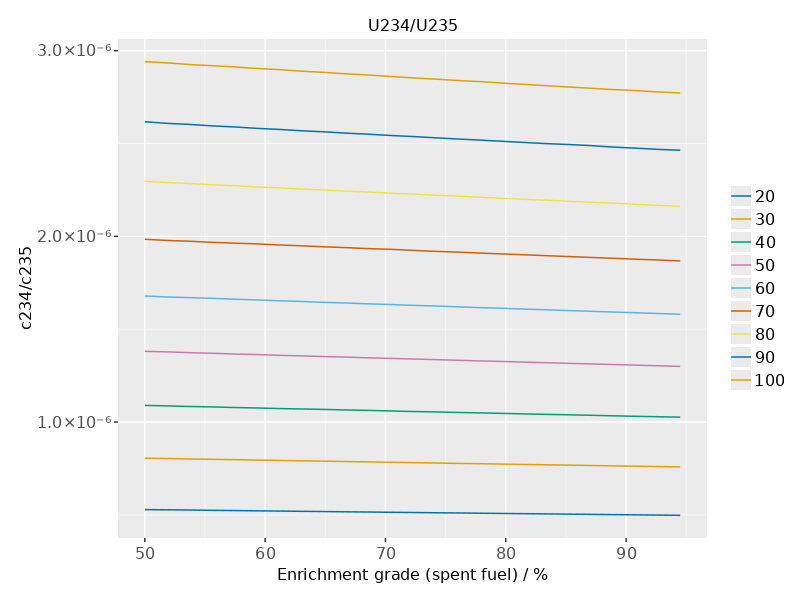

In [156]:
by_cycle_time = DF.groupby(
    DF.select(cyclerichment, :cycle_time, :enrichment, :U234, :U235, :U236,
        ["U234", "U235"] => (./) => :r34_35,
        ["U236", "U235"] => (./) => :r36_35,
        ["U235", "U238"] => (./) => :r35_38),
    :cycle_time)

fig = CM.Figure()
ax = CM.Axis(fig[1,1], xlabel="Enrichment grade (spent fuel) / %", ylabel="c234/c235", title="U234/U235")
for f in by_cycle_time[1:3:end]
    #CM.lines!(ax, f.enrichment, f.r34_35, label="$(f.cycle_time[1]) 234/235")
    #CM.lines!(ax, f.enrichment, f.r36_35, label="$(f.cycle_time[1]) 236/235")
    CM.lines!(ax, f.enrichment, f.r34_35, label="$(round(Int, f.cycle_time[1]))")
end
fig[1,2] = CM.Legend(fig, ax)
fig

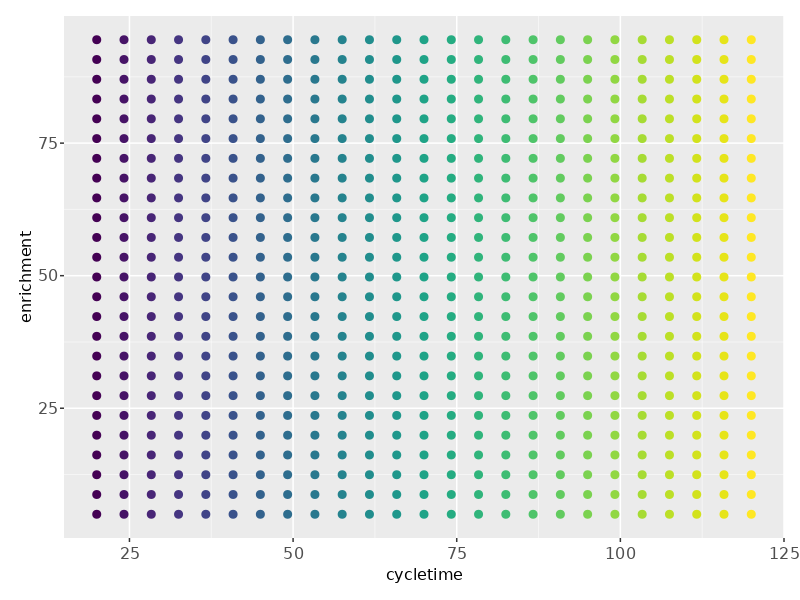

In [163]:
fig = CM.Figure()
ax = CM.Axis(fig[1,1], xlabel="cycletime", ylabel="enrichment")
CM.scatter!(ax, cyclerichment_alliso.cycle_time, cyclerichment_alliso.high_enrichment_grade, color=@view cyclerichment_alliso[!, "PlutoniumSink:942400000"])
fig

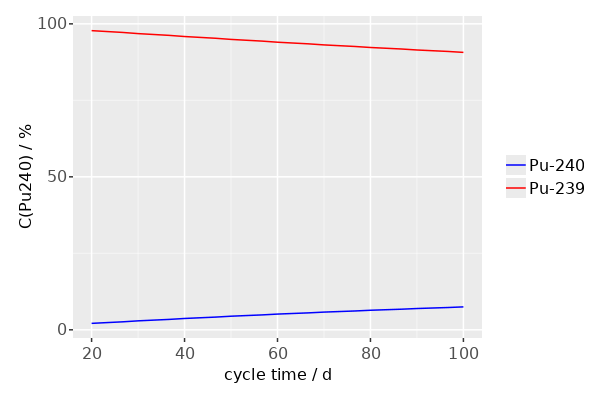

In [176]:
at90pct = DF.filter(:enrichment => e -> 89 < e < 91, cyclerichment)

fig = CM.Figure(resolution=(600,400))
ax = CM.Axis(fig[1,1], xlabel="cycle time / d", ylabel="C(Pu240) / %")
StatsPlots.@df at90pct CM.lines!(ax, :cycle_time, 100 * :Pu240, color=:blue, label="Pu-240")
StatsPlots.@df at90pct CM.lines!(ax, :cycle_time, 100 * :Pu239, color=:red, label="Pu-239")
fig[1,2] = CM.Legend(fig, ax)
CM.save("out/pu240_over_cycletime.pdf", fig)
fig

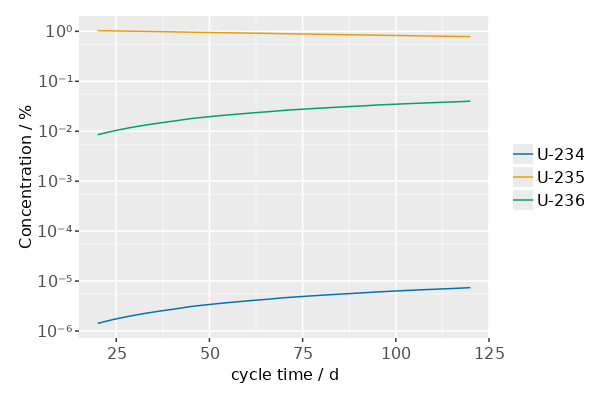

In [19]:
alliso_at90 = DF.filter(:high_enrichment_grade => e -> 89 < e < 91, cyclerichment_alliso)

fig = CM.Figure(resolution=(600,400))
ax = CM.Axis(fig[1,1], xlabel="cycle time / d", ylabel="Concentration / %", yscale=CM.log10)
for (i, iso) in enumerate([:SeparatedWasteSink_922340000, :SeparatedWasteSink_922350000, :SeparatedWasteSink_922360000])
    StatsPlots.@df alliso_at90 CM.lines!(ax, :cycle_time, 100 * alliso_at90[!, iso], label="U-$(233+i)")
end
fig[1,2] = CM.Legend(fig, ax)
CM.save("out/u_iso_burnup.pdf", fig)
fig

In [29]:
sum(([1,2,3], [2,3,4]))

3-element Vector{Int64}:
 3
 5
 7

In [45]:
uraniumisos = DF.select(alliso_at90, :cycle_time, :high_enrichment_grade,
    DF.Cols(r"SeparatedWasteSink_92.*") => (+) => :allu, DF.Cols(r"SeparatedWasteSink_92.*"),
    DF.Cols(r"SeparatedWasteSink_92.*") => ( (cols...) -> let s = sum(cols); tuple([col / s for col in cols]) end),
)

25×9 DataFrame
 Row │ cycle_time  high_enrichment_grade  allu      SeparatedWasteSink_9223400 ⋯
     │ Float64     Float64                Float64   Float64                    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    20.0                   90.7708  0.982531                    1.42052e ⋯
   2 │    24.1667                90.7708  0.979582                    1.69571e
   3 │    28.3333                90.7708  0.976667                    1.96787e
   4 │    32.5                   90.7708  0.973767                    2.23682e
   5 │    36.6667                90.7708  0.970872                    2.50247e ⋯
   6 │    40.8333                90.7708  0.96798                     2.76477e
   7 │    45.0                   90.7708  0.964368                    3.08795e
   8 │    49.1667                90.7708  0.961487                    3.34279e
   9 │    53.3333                90.7708  0.958617                    3.59441e ⋯
  10 │    57.5                   90.7708  0.955764                    3.8429e-
  11 │    61.6667                90.7708  0.95293                     4.08834e
  ⋮  │     ⋮                 ⋮               ⋮                   ⋮             ⋱
  16 │    82.5                   90.7708  0.938379                    5.32941e
  17 │    86.6667                90.7708  0.93566                     5.55703e ⋯
  18 │    90.8333                90.7708  0.932953                    5.78186e
  19 │    95.0                   90.7708  0.929589                    6.05897e
  20 │    99.1667                90.7708  0.926913                    6.27752e
  21 │   103.333                 90.7708  0.924251                    6.49325e ⋯
  22 │   107.5                   90.7708  0.921607                    6.70616e
  23 │   111.667                 90.7708  0.91898                     6.91622e
  24 │   115.833                 90.7708  0.91637                     7.12338e
  25 │   120.0                   90.7708  0.913132                    7.37816e ⋯
                                                    6 columns and 4 rows omitted

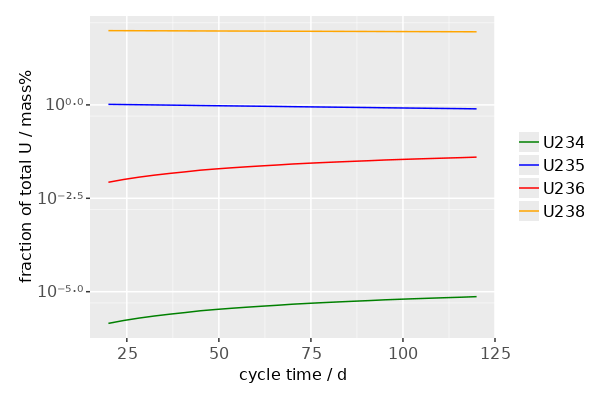

In [69]:
fig = CM.Figure(resolution=(600,400))
ax = CM.Axis(fig[1,1], xlabel="cycle time / d", ylabel="fraction of total U / mass%", yscale=CM.log10)
StatsPlots.@df uraniumisos CM.lines!(ax, :cycle_time, 100 * :SeparatedWasteSink_922340000, color=:green, label="U234")
StatsPlots.@df uraniumisos CM.lines!(ax, :cycle_time, 100 * :SeparatedWasteSink_922350000, color=:blue, label="U235")
StatsPlots.@df uraniumisos CM.lines!(ax, :cycle_time, 100 * :SeparatedWasteSink_922360000, color=:red, label="U236")
StatsPlots.@df uraniumisos CM.lines!(ax, :cycle_time, 100 * :SeparatedWasteSink_922380000, color=:orange, label="U238")
fig[1,2] = CM.Legend(fig, ax)
CM.save("out/u_235_separated_waste.pdf", fig)
fig